As Moira says,
OH HELLO YOU! 
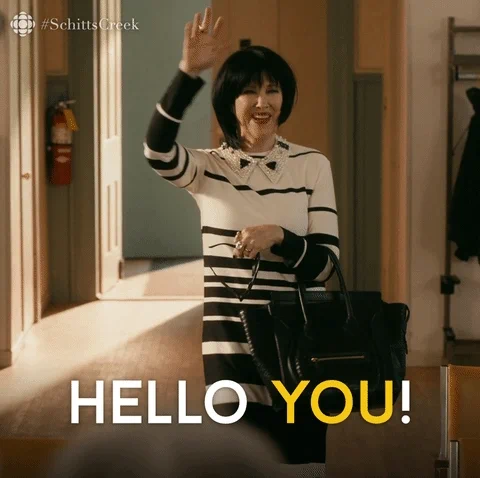

Today, I shall be analyzing an A/B Test that I conducted over the past 5-6 days.
It had been almost 3 years since I had learned about A/B tests and I wanted to do it all over again (for good reason!).

**"So Sankalp, an A/B test eh? What the heck is that?"**

Simple! 
A/B tests are a way to quantify how **one** change affects the statue-quo for a given process.

**"What do you mean?"**

Suppose your website has a blue background right now. You want to know how your viewership is affected if you change the background to red. How would you do this?

Through an A/B Test.

**"What is this A and B"?**

So, the A and B stand for the status Quo (A) and New-Version (B) of the website you are testing.
Ideally, the only difference between A (website with Blue Background) and B (website with Red Background) should be the background color and nothing else. Not even functionality.

We call A the "Control" and "B" as the Treatment. The measurement is site hits.
In a hypothetical world, we would show both sites as "fresh" to the same set of people, as if we cloned everyone and one clone saw A and the other saw B. Unfortunately, that is not how the world works. 

Hence, we would show a certain population of people the Control site and a non-overlapping population the Treatment site. And we want to assign these populations randomly as this would help reduce the general differences between the two groups.
We want both the groups to be as near-clones as possible, especially in their behavorial characterstics, in order to reduce any potential errors in judgement.

**"Okay, enough talk, specify what you are testing!"**


I am testing if the lenght of a blank on a Google form affects the average length of a sentence that the surveyor fills.

This is how the control site looks like - 
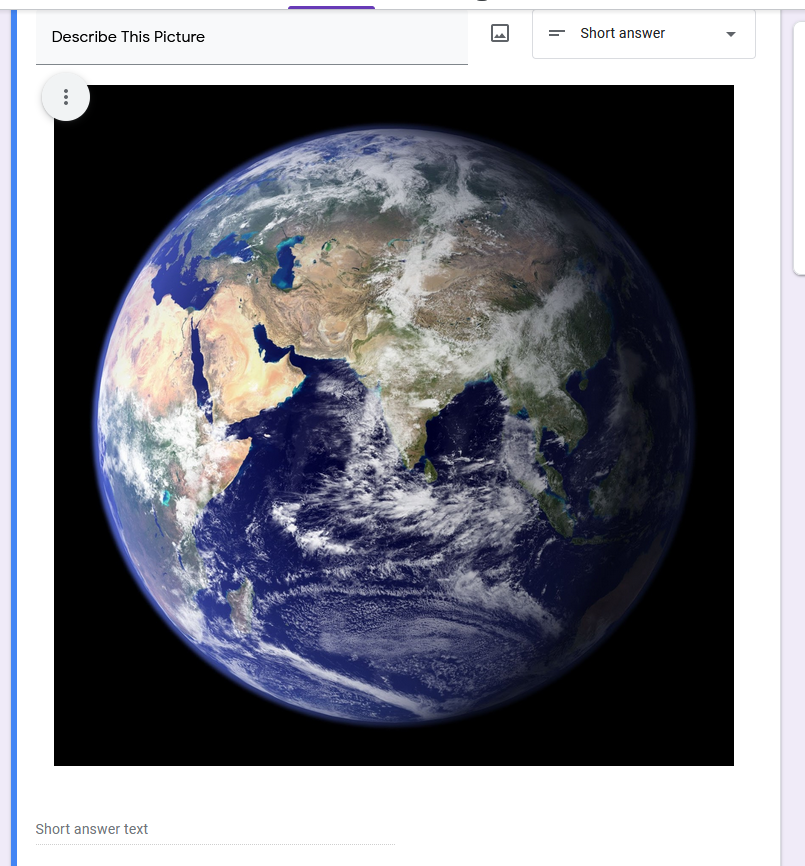

And this is how the Treatment site looks like - 
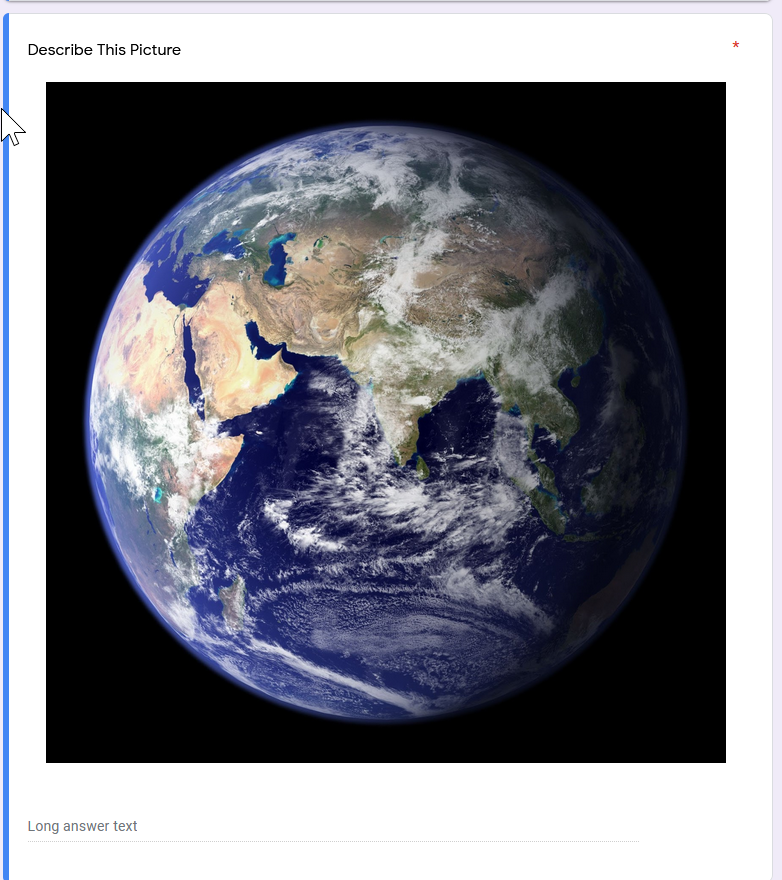

The respondents of the survey were provided the following link - https://rb.gy/7dqnyy - which randomly assigned one of the two versions of the website.

After running the test, I downloaded the corresponding CSVs and uploaded on Google Colab to perform my analysis.

The analysis is as follows -

In [1]:
#Imports
import pandas as pd
import numpy as np
import math
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read Files
para = pd.read_csv('/content/Paragraph.csv')
short = pd.read_csv('/content/Short Answer.csv')

short = short.rename(columns={'Education Level': 'Highest Education Level'})

para['Group'] = 'Treatment'
short['Group'] = 'Control'

dataset = para.append(short)
del(para)
del(short)

In [3]:
#DataType Formatting
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp']).dt.date
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Occupation or Major'] = dataset['Occupation or Major'].astype('category')
dataset['Age'] = dataset.Age.astype('category').cat.set_categories(new_categories = ['13-18', '19-24', '25-30','31-40','41-60','60+'], ordered = True)
dataset['Highest Education Level'] = dataset['Highest Education Level'].astype('category').cat.set_categories(new_categories = ['No Formal Education', 'High School',
                                                                                                 'Bachelors', 'Masters', 'Double Masters', 'PhD']
                                                                                                 , ordered = True)
dataset['Group'] = dataset['Group'].astype('category')

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [4]:
#Data Derivation or Transformation
dataset.drop_duplicates(subset= 'Username', keep= 'first')
dataset['TotalWords'] = dataset['Describe This Picture'].apply(lambda x: len(x.split()))
dataset.drop(columns='Username', inplace= True)

Now that we have our base dataset, we shall explore the nature of our data

In [5]:
#Counts
control_count = dataset[dataset.Group == 'Control']['Group'].count()
treatment_count = dataset[dataset.Group == 'Treatment']['Group'].count()

print('The dataset has %s responses in control and %s responses in treatment' % (control_count, treatment_count))

The dataset has 22 responses in control and 22 responses in treatment


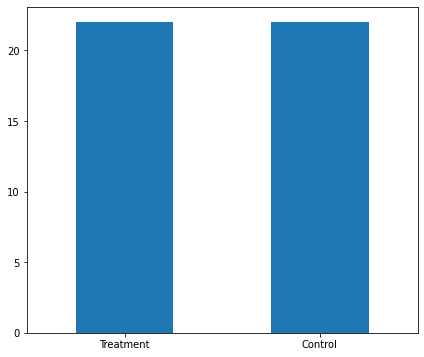

In [6]:
dataset['Group'].value_counts().plot(kind= 'bar', figsize= (7, 6), rot= 0)

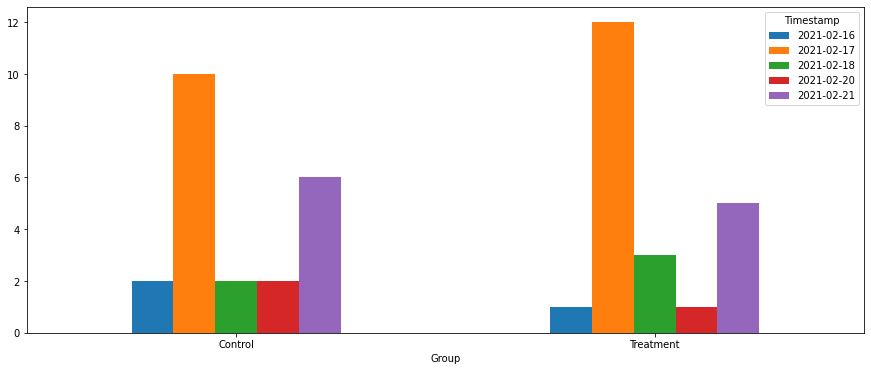

In [7]:
dataset.groupby('Group').Timestamp.value_counts().unstack().plot.bar( figsize= (15, 6), rot= 0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f85145547d0>,
      dtype=object)

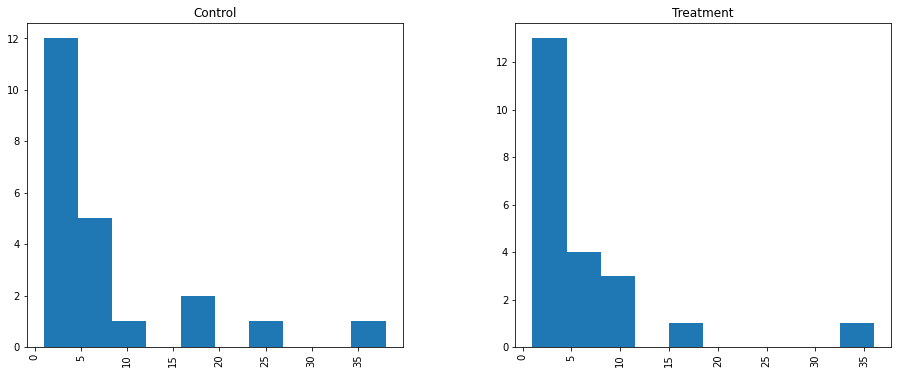

In [8]:
dataset.hist(column='TotalWords',by= 'Group', figsize= (15, 6) )

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


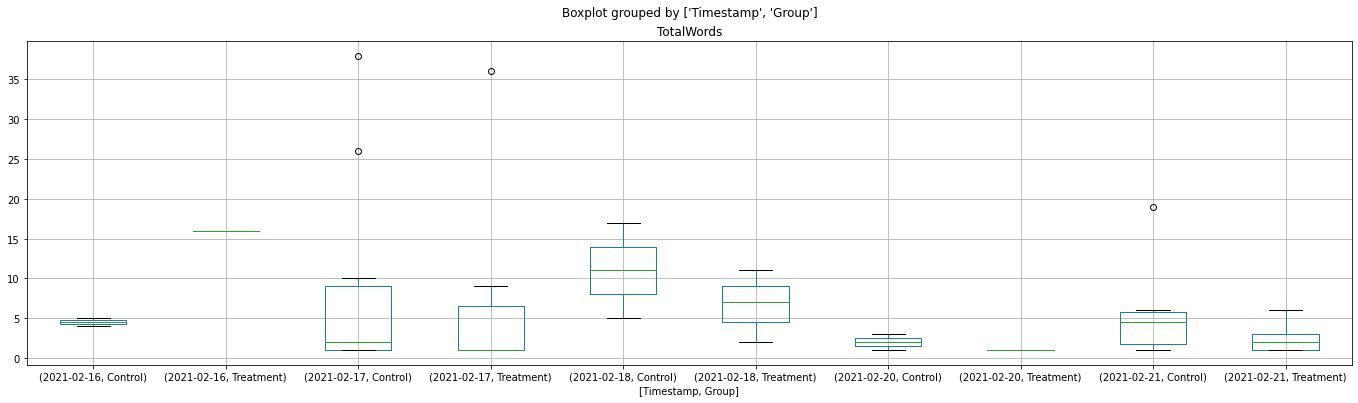

In [9]:
dataset.boxplot(column='TotalWords', by=['Timestamp', 'Group'], figsize= (23,6))

Based on the counts and the box plot, it would make sense to use only dates where we had 3 or more items in both treatment and control.

In [10]:
dataset = dataset.merge(dataset.groupby(['Group','Timestamp']).size().reset_index(name='counts'), on=['Group', 'Timestamp'])
dataset_countfiltered = dataset[dataset['counts'] >= 3]

In [12]:
base = dataset_countfiltered.groupby(['Timestamp', 'Group'], as_index= False).mean()

In [15]:
stats.ks_2samp(base[base.Group.isin(['Treatment'])]['TotalWords'], base[base.Group.isin(['Control'])]['TotalWords'])

Ks_2sampResult(statistic=0.6666666666666666, pvalue=0.6)

In [16]:
stats.ttest_ind(base[base.Group.isin(['Treatment'])]['TotalWords'], base[base.Group.isin(['Control'])]['TotalWords'], equal_var= False, nan_policy= 'omit')

Ttest_indResult(statistic=-1.2273576028349553, pvalue=0.3238967955831716)

The p value is > 0.05 and hence, we cannot reject the null hypothesis at a 95% confidence.
That is disappointing. Probably the lack of data or maybe there is more at play?

Let us dig deeper into the different characteristics of our treatment and control

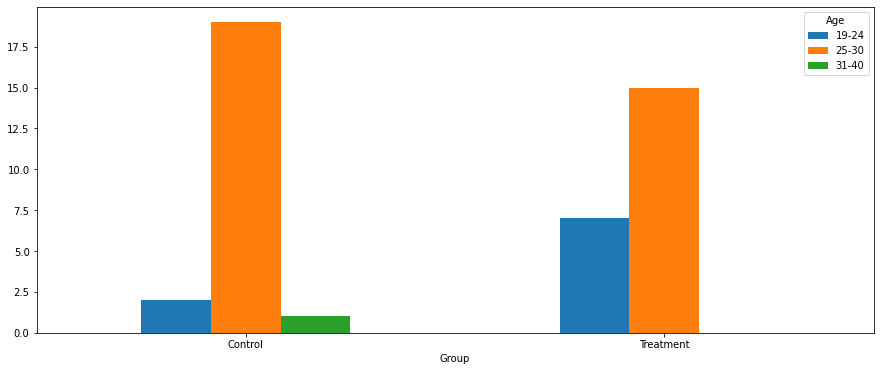

In [14]:
##Age Group
dataset.groupby('Group').Age.value_counts().unstack().plot.bar( figsize= (15, 6), rot= 0)

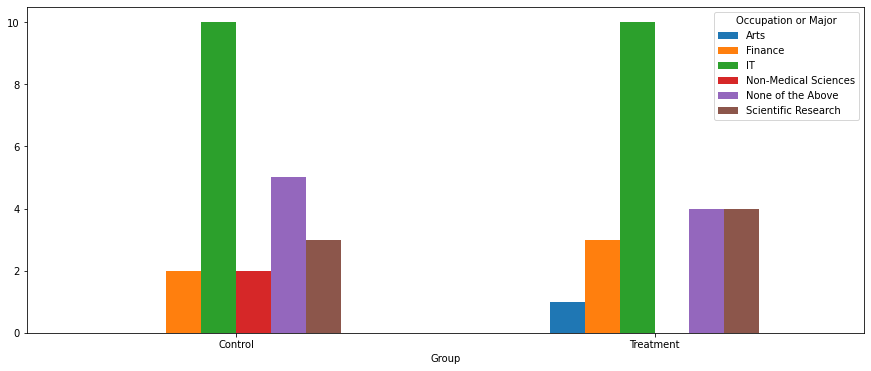

In [17]:
##Age Group
dataset.groupby('Group')['Occupation or Major'].value_counts().unstack().plot.bar( figsize= (15, 6), rot= 0)

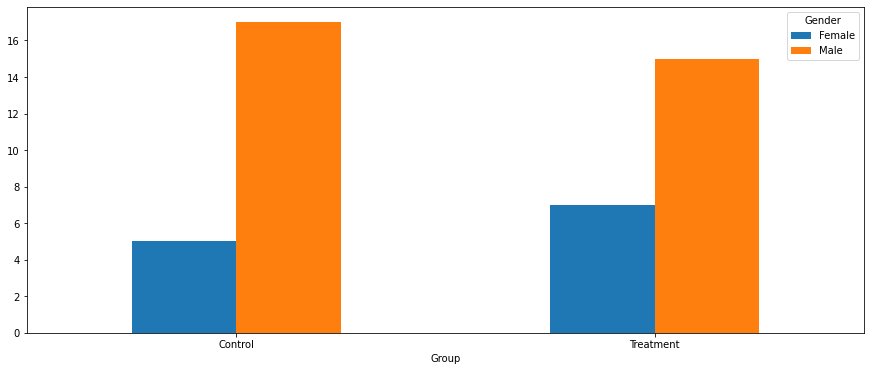

In [18]:
dataset.groupby('Group')['Gender'].value_counts().unstack().plot.bar( figsize= (15, 6), rot= 0)

As we can see, 
There is a major imbalance in the dataset where we have a lot more 24-30 year olds in both treatment and control.
The same can be said about IT majors and for Males.

Maybe, if we test on Males or IT majors or 24-30 year olds, we might see a different trend.

In [22]:
dataset_ITmajor = dataset[dataset['Occupation or Major'] == 'IT']
base = dataset_ITmajor.groupby(['Timestamp', 'Group'], as_index= False).mean()
print(base)
stats.ttest_ind(base[base.Group.isin(['Treatment'])]['TotalWords'], base[base.Group.isin(['Control'])]['TotalWords'], equal_var= False, nan_policy= 'omit')

    Timestamp      Group  TotalWords  counts
0  2021-02-16    Control    5.000000     2.0
1  2021-02-16  Treatment         NaN     NaN
2  2021-02-17    Control    1.400000    10.0
3  2021-02-17  Treatment    7.666667    12.0
4  2021-02-18    Control   11.000000     2.0
5  2021-02-18  Treatment   11.000000     3.0
6  2021-02-20    Control    1.000000     2.0
7  2021-02-20  Treatment         NaN     NaN
8  2021-02-21    Control    1.000000     6.0
9  2021-02-21  Treatment         NaN     NaN


Ttest_indResult(statistic=2.136972437134723, pvalue=0.10331851023694426)

In [24]:
dataset_2430 = dataset[dataset['Age'] == '25-30']
base = dataset_2430.groupby(['Timestamp', 'Group'], as_index= False).mean()
print(base)
stats.ttest_ind(base[base.Group.isin(['Treatment'])]['TotalWords'], base[base.Group.isin(['Control'])]['TotalWords'], equal_var= False, nan_policy= 'omit')

    Timestamp      Group  TotalWords  counts
0  2021-02-16    Control    4.500000     2.0
1  2021-02-16  Treatment   16.000000     1.0
2  2021-02-17    Control    9.666667    10.0
3  2021-02-17  Treatment    8.857143    12.0
4  2021-02-18    Control   11.000000     2.0
5  2021-02-18  Treatment    7.000000     3.0
6  2021-02-20    Control    1.000000     2.0
7  2021-02-20  Treatment    1.000000     1.0
8  2021-02-21    Control    3.400000     6.0
9  2021-02-21  Treatment    2.600000     5.0


Ttest_indResult(statistic=0.36169208741690045, pvalue=0.7278699532209534)

In [25]:
dataset_male = dataset[dataset['Gender'] == 'Male']
base = dataset_male.groupby(['Timestamp', 'Group'], as_index= False).mean()
print(base)
stats.ttest_ind(base[base.Group.isin(['Treatment'])]['TotalWords'], base[base.Group.isin(['Control'])]['TotalWords'], equal_var= False, nan_policy= 'omit')

    Timestamp      Group  TotalWords  counts
0  2021-02-16    Control    4.500000     2.0
1  2021-02-16  Treatment   16.000000     1.0
2  2021-02-17    Control    9.444444    10.0
3  2021-02-17  Treatment    3.272727    12.0
4  2021-02-18    Control   17.000000     2.0
5  2021-02-18  Treatment    6.666667     3.0
6  2021-02-20    Control    2.000000     2.0
7  2021-02-20  Treatment         NaN     NaN
8  2021-02-21    Control    3.666667     6.0
9  2021-02-21  Treatment         NaN     NaN


Ttest_indResult(statistic=0.2831712736254505, pvalue=0.7909736648685287)

As we can see,
It is inconclusive to state that the long blank for the description has an effect on the average length of the sentence filled by the surveyors.

I would like to mention that this test is flawed in its premise.
I will list the pros and cons

Pros -
*   Our Control and Treatment groups were **successfully randomized**, as noted from the number of observations
*   Depending on our level of confidence, we could reject the Null hypothesis and state that the blank length did make a difference for IT professionals or majors

Cons - 

*   The experiment is randomized but the **control and treatment group is not the same** for all the day. This is due to the method of survey delivery. 
I did not have the tools (given time) to send the same survey to the same - randomly allocated - people in treatment and in control group. Hence, we had to use anova to see if the samples on different days are appx from the same distribution
*   We did **not get enough responses** to have a substantial A/B test. Out of the 5 days, we only got 2 days where responses on both A and B were >= 5
*   The number of days the test was run may not be enough. There could have been more responses, especially ones that we could use for our analysis
*   I specifically asked people not to fill the survey multiple times and only chose their first response. **This was an anti-troll mechanism**.
This was because I could not guarantee that a given userid would get the same version of the website. 
In my analysis, for the ones who might have filled both versions, I only end up considering their first version.





There was still a lot I learned from this experiment and I certainly plan on running better tests over the next few months. It improves my ability to use statistics and improves my understanding of the world of website design (which involves elements of arts, science, psychology, and commerce).

Until then, I shall leave you with another great line by our beloved Mr. Kim!

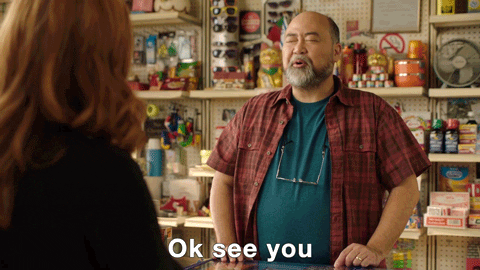